## Step 0: Importing the Appropriate Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy
import emcee
import corner
import os
import glob

import astropy.constants as ac
from astropy import units as u
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.modeling import models
from astropy.visualization import quantity_support
from scipy.optimize import minimize
from scipy import interpolate

## Step 1: Importing Data and Changing the Units of the Variables

We'll first import and read the following data:

1. chen+07_slshlh.dat; This contains the Spitzer IRS spectrum of BetaPic from ~5-35 microns. 

2. betapic_fluxes.dat; This contains assorted photometry from the optical and infrared with BetaPic. 

3. betapic_lws_cnt3_.txt; This contains the ISO LWS spectrum of BetaPic, from ~43 to 160 microns.

### 1.1: Using the correct folders to pull the data from and to put the data in

In [3]:
# to change to main directory
os.chdir('..')
cwd = os.getcwd()

# then the appropriate folders inside this main directory
Photom_IRS = cwd + "\\data\\betapic_data\DiskModels\Debris\BetaPic" # where the photometry and IRS Spectrum is found
LWS = cwd + "\\data\\betapic_data\DiskModels\Debris\BetaPic\iso\hpdp_62003530_3" # where the LWS Spectrum is found

Ice = cwd + "\\data\\water_ice_opacities_lsbrp" # where the different opacity files are found
Silicates = cwd + "\\data\\silicates_for_betapic" # where the different silicate files are found

C:\Users\SPJHe\Downloads\BRP


### 1.2: Importing the Data 

In [4]:
# Changing directory to the photometry and IRS Spectrum files
os.chdir(Photom_IRS)

# Columns are all labelled (wavelength in microns, flux (F_nu) and uncertainty in Janskys, (Jy)).
Spitzer_IRS = np.loadtxt('chen+07_slshlh.dat')
Wavelength_IRS, Flux_IRS_Jy, Error_IRS_Jy = Spitzer_IRS[:,0], Spitzer_IRS[:,1], Spitzer_IRS[:,2]

# Columns are formatted as wavelength (mircons), flux (F_nu, Jy), uncertainty (Jy).
Photom = np.loadtxt('betapic_fluxes.dat')
Wavelength_Photom, Flux_Photom_Jy, Error_Photom_Jy = Photom[:,0], Photom[:,1], Photom[:,2]


# Changing directory to the LWS Spectrum file
os.chdir(LWS)

# Columns are formatted  as wavelength (microns), nu*F_nu (erg/cm^2/s), and uncertainty in nu*F_nu (same units).
ISO_LWS = np.loadtxt('betapic_lws_cnt3_.txt')
Wavelength_LWS, Flux_LWS, Error_LWS = ISO_LWS[:,0], ISO_LWS[:,1], ISO_LWS[:,2]

### 1.3: Rewriting the units
We need to convert the fluxes and error from Jansky to erg cm$^{-2}$ s$^{-1}$ . We know that 1 Jy equals to 10$^{23}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$.

Such that we get: erg cm$^{-2}$ s$^{-1}$ = 10$^{-23}$ Hz Jy

In [4]:
# We can now calculate the flux using F = v*F_v (also making sure that the wavelength is in meters and not in microns)
Flux_IRS = 10**(-23)*Flux_IRS_Jy*(ac.c.value/(Wavelength_IRS*10**(-6)))
Flux_Photom = 10**(-23)*Flux_Photom_Jy*(ac.c.value/(Wavelength_Photom*10**(-6)))

# We can now also calculate the error in the fluxes
Error_IRS = 10**(-23)*Error_IRS_Jy*(ac.c.value/(Wavelength_IRS*10**(-6)))
Error_Photom = 10**(-23)*Error_Photom_Jy*(ac.c.value/(Wavelength_Photom*10**(-6)))

In [5]:
# Making sure no flux is zero/negative
Flux_IRS, Wavelength_IRS, Error_IRS = Flux_IRS[Flux_IRS>0], Wavelength_IRS[Flux_IRS>0], Error_IRS[Flux_IRS>0]
Flux_Photom, Wavelength_Photom, Error_Photom = Flux_Photom[Flux_Photom>0], Wavelength_Photom[Flux_Photom>0], Error_Photom[Flux_Photom>0]

# Removing the negative values
Flux_LWS, Wavelength_LWS, Error_LWS = Flux_LWS[Flux_LWS>0], Wavelength_LWS[Flux_LWS>0], Error_LWS[Flux_LWS>0]

# Removing the error equal to 0 from the photometry
Error_Photom, Flux_Photom, Wavelength_Photom = Error_Photom[Error_Photom!=0], Flux_Photom[Error_Photom!=0], Wavelength_Photom[Error_Photom!=0]

We need to convolve LWS Spectrum to smoothen it

In [6]:
# Create kernel & convolving lWS spectrum
g = Gaussian1DKernel(stddev=3)
z = convolve(Flux_LWS, g)

# Removing the tail of the LWS spectrum [by trial and error]
Wavelength_z, z, Error_z = Wavelength_LWS[6:], z[6:], Error_LWS[6:]

## MCMC Fit

In [7]:
def spectrum(wave, x0):
    """Calculates the flux as (v*F_v [v = frequency]) for a given temperature and 
    a given solid angle. This model is equal to a blackbody"""
    T, SolidAngle = x0

    bb = models.BlackBody(temperature=T*u.K)
    B_q = bb(wave*u.micron)
    
    F = ((SolidAngle*10**(-13))*u.sr)*B_q*(ac.c/(wave*u.micron))
    return F.to(u.erg * u.cm**(-2) * u.s**(-1)).value


def chi_sq(model, flux, error):
    """Calculates the chi squared value."""
    return np.sum(((model-flux)/error)**2)

def chi_squared(x0, wave, flux, error):
    """Calculates the reduced chi^2 value for a given set of parameters and data points
    (with the corresponding errors) for a certain model. This definition is for the 
    the determination of the reduced chi^2 value of the flux of a model."""
    F = spectrum(wave, x0)
    chi = chi_sq(F, flux, error)
    return chi/(len(F))

In [8]:
def lnL(x0, wave, flux, error):
    """Calculates the ln of the likelihood from the parameters and data points."""
    chi = chi_squared(x0, wave, flux, error)
    return -chi/2

def ln_prior(x0, x0_guess, sigma):
    """Calculates the prior from the parameters, an initial guess for these paramters, 
    and some deviations for the parameters (sigma)."""
    T, SA   = x0
    T_g, SA_g = x0_guess
    sig_T, sig_SA = sigma
    
    prior_T = np.exp(-(T-T_g)**(2)/(2*sig_T**(2)))
    prior_SA = np.exp(-(SA*10**(-13) - SA_g*10**(-13))**2 / (2 * (sig_SA*10**(-13))**2))
    
    return prior_T * prior_SA

def ln_prob(x0, x0_guess, sigma, wave, flux, error):
    """Calculates the likelihood to include in the MCMC calculations."""
    for i in x0:
        if i <= 0:
            return -np.inf
    lp = ln_prior(x0, x0_guess, sigma)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnL(x0, wave, flux, error)

### Setting Up the Variables for the MCMC Simulation

In [9]:
# Set up the properties of the problem. We want to fit ndim parameters with a certain amount of walkers
ndim, nwalkers = 2, 500

# Guess at a solution
x0_guess = [1.39056500, 3.17966007] # in order of magnitude [e2, e-13]
sigma = [10, 0.5]

### Running the MCMC Simulation

In [10]:
pos = [x0_guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Create the sampler. 
sampler_bb = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, args=(x0_guess, sigma, Wavelength_Photom[Wavelength_Photom>10],
                                                      Flux_Photom[Wavelength_Photom>10], Error_Photom[Wavelength_Photom>10]))
tmp = sampler_bb.run_mcmc(pos, 500, progress = True)

C:\Users\SPJHe\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  3%|▎         | 17/500 [00:21<09:54,  1.23s/it]C:\Users\SPJHe\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 500/500 [14:21<00:00,  1.72s/it]


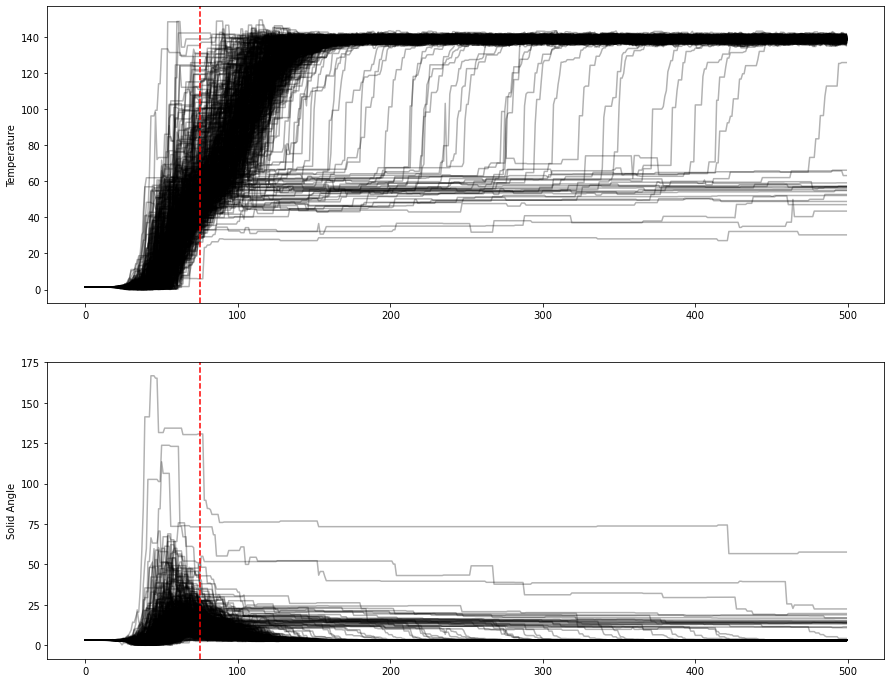

In [11]:
# Plot the walkers to cut off the burn-in time

burnin = 75

fig, axes = plt.subplots(ncols = 1, nrows = ndim)
fig.set_size_inches(15,12)

axes[0].plot(sampler_bb.chain[:, :, 0].transpose(), color = 'black', alpha = 0.3)
axes[0].set_ylabel('Temperature')
axes[0].axvline(burnin, ls='dashed', color = 'red')
axes[1].plot(sampler_bb.chain[:, :, 1].transpose(), color = 'black', alpha = 0.3)
axes[1].set_ylabel('Solid Angle')
axes[1].axvline(burnin, ls='dashed', color = 'red')

plt.show()
plt.close()

### Making a Corner Plot to See the Results

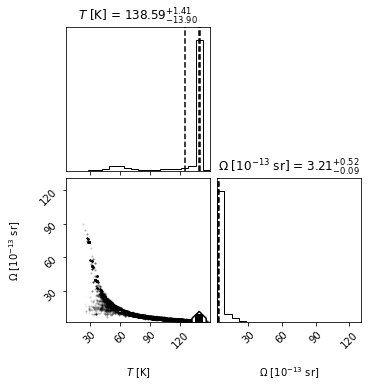

In [12]:
# Making sure that the figure will be saved in the main directory
os.chdir(cwd)

# Finally, we make a corner plot of everything
samples_bb = sampler_bb.chain[:, burnin:, :].reshape((-1, ndim))

fig = corner.corner(samples_bb, labels = ["$T$ [K]","$\Omega$ [$10^{-13}$ sr]"],\
                   quantiles = [0.16, 0.5, 0.84], show_titles = True, title_kwargs={"fontsize": 12})

plt.show()
plt.close()

In [13]:
print("T:", np.median(samples_bb[:,0]),"K")
print("$\Omega$:", np.median(samples_bb[:,1]),"e-13 sr")

T: 138.5931816452781 K
$\Omega$: 3.2054126272929997 e-13 sr
